# Data Cleaning and Setup

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')
import warnings
warnings.filterwarnings('ignore')
 
# Definfe the stock and ETFs universe
ETFs_universe = ['MGC', 'MGK', 'MGV', 'MTUM', 'QQQ', 'SDY', 'SPLV', 'VB', 
                 'VBK', 'VBR', 'VCR', 'VDC', 'VDE', 'VFH', 'VGT', 'VHT', 'VIG',
                 'VIS', 'VNQ', 'VO', 'VOE', 'VOT', 'VOX', 'VPU', 'VTV', 'VUG',
                 'VV', 'VYM', 'XBI', 'XLB', 'XLC', 'XLI', 'XLK', 'XLV', 'XME']


# Extract historiacl data from IEX
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import Stock
from datetime import datetime
from datetime import timedelta
import os

# Authenticate the IEX with token
os.environ['IEX_API_VERSION'] = 'iexcloud-sandbox'
os.environ['IEX_TOKEN'] = 'Tpk_xxxxxxxx' # put your own token here

# Fetch the data from IEX
start_date = datetime.now() - timedelta(days = 365*10)
data = []

df = pd.DataFrame(columns=['symbol', 'fClose', 'changePercent'])
return_table = pd.DataFrame()

# Fetch the data

In [2]:
for s in ETFs_universe:
    df_extract = get_historical_data(s, start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
    return_data = pd.to_numeric(df_extract.changePercent)
    return_table[s] = return_data
    df = df.append(df_extract)
    
# Change datatype into numeric
df.changePercent = pd.to_numeric(df.changePercent)
df.fClose = pd.to_numeric(df.fClose)
df.head()

,symbol,fClose,changePercent
2011-05-24,MGC,38.0656,-0.0007
2011-05-25,MGC,37.6235,0.0031
2011-05-26,MGC,37.4622,0.0040
2011-05-27,MGC,37.8745,0.0034
2011-05-31,MGC,37.9899,0.0111


# Momemtum Filter

In [3]:
return_table.head()

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
2011-05-24,-0.0007,-0.0015,-0.0005,NaN,-0.0064,-0.0022,0.0005,-0.0035,-0.0030,-0.0040,...,-0.0013,-0.0005,-0.0020,-0.0107,0.0050,NaN,-0.0052,-0.0032,-0.0029,0.0091
2011-05-25,0.0031,0.0035,0.0030,NaN,0.0039,-0.0007,-0.0020,0.0108,0.0135,0.0079,...,0.0046,0.0032,0.0018,0.0157,0.0144,NaN,0.0086,0.0031,0.0014,0.0194
2011-05-26,0.0040,0.0049,0.0025,NaN,0.0062,0.0027,-0.0008,0.0118,0.0128,0.0102,...,0.0066,0.0045,0.0024,0.0089,0.0024,NaN,0.0042,0.0067,0.0014,0.0097
2011-05-27,0.0034,0.0044,0.0046,NaN,0.0050,0.0027,0.0040,0.0060,0.0070,0.0070,...,0.0040,0.0049,0.0025,0.0077,0.0109,NaN,0.0051,0.0050,0.0006,0.0102
2011-05-31,0.0111,0.0108,0.0104,NaN,0.0163,0.0095,0.0071,0.0125,0.0122,0.0122,...,0.0106,0.0103,0.0094,0.0076,0.0102,NaN,0.0094,0.0139,0.0122,0.0152


In [4]:
def momemtum_ranking_table(df, t, n):
    # lookback period = t weeks
    # select top n stock
    
    # create a ranking table (smaller the ranking, higher the return)
    ranking = resample_risk_adjusted_retrun_table(df, t).shift(1).rank(axis=1, na_option='keep', ascending = False)

    original_rank = list(range (1, len(ETFs_universe)+1))
    replace_rank = [1]*n + [0]*(len(ETFs_universe)-n)

    ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank, make the value of top n as 1, all others as 0
    
    return ranking_matrix

def cumulative_return(return_vals):
    # convert daily retrun into any cumulative return we want
    
    cumulative_return_list = (np.array(return_vals)+1).cumprod() -1
    
    return cumulative_return_list[-1]

def resample_retrun_table(df, t):
    # for actual backtesting, we need the actual retrun(un-risk-adjusted)
    
    # df is the daily return table (the most recent datetime should at the bottom of the table)
    # t is the number of week we want to resample into
    # W-Fri: W means weekly, while Fri means use Friday to represent the week
    # We rebalance the position on the close price of Friday
    
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x)) # turn the dataframe into weekly 
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])

    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    
    return rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1].iloc[1:] # turn the table upside dowm, then select every t-th row, the turn around the table again 

def resample_risk_adjusted_retrun_table(df, t):
    # for ranking propose, we need risk adjusted return
    
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x))
    risk = df.rolling(window=5*t).std()# turn the dataframe into weekly 
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])

    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    resample_return_table = rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1].iloc[1:]
    
    return resample_return_table.mul(1/risk).dropna(how='all') # multiply element-wise

def portfolio_retrun_table(df, t, n):
    return momemtum_ranking_table(df, t, n).mul(resample_retrun_table(df, t)).sum(1)*(1/n) # equal weighted here

def plot_maximum_drawdown(df, t, n):
    wealth_index=(1+portfolio_retrun_table(df,t,n)).cumprod()
    plt.plot(wealth_index)
    previous_peaks = pd.Series(wealth_index).cummax()
    previous_peaks.plot()

In [5]:
resample_retrun_table(return_table, 2)

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
2011-06-17,-0.021404,-0.030076,-0.011417,NaN,-0.045890,-0.013363,-0.004762,-0.029569,-0.039995,-0.021699,...,-0.032196,-0.024561,-0.008616,-0.048316,-0.038151,NaN,-0.018261,-0.043368,-0.012637,-0.081906
2011-07-01,0.049363,0.060992,0.034860,NaN,0.078602,0.041832,0.028779,0.076065,0.088442,0.062253,...,0.064280,0.052411,0.033480,0.066697,0.086254,NaN,0.069711,0.070039,0.034927,0.114829
2011-07-15,-0.016448,-0.006850,-0.024354,NaN,-0.001095,-0.016682,-0.020418,-0.014457,-0.013117,-0.017045,...,-0.009277,-0.016301,-0.012279,0.004627,-0.004388,NaN,-0.037361,-0.007563,-0.021994,-0.010991
2011-07-29,-0.016024,-0.009150,-0.023868,NaN,0.003044,-0.034305,-0.018314,-0.038013,-0.042204,-0.034204,...,-0.013933,-0.018085,-0.027891,-0.041274,-0.040159,NaN,-0.052518,-0.004196,-0.031754,-0.037483
2011-08-12,-0.086626,-0.081162,-0.094480,NaN,-0.078130,-0.061719,-0.045873,-0.122175,-0.118944,-0.122613,...,-0.084263,-0.090987,-0.070388,-0.160855,-0.098353,NaN,-0.098614,-0.067585,-0.078641,-0.143915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,0.004290,0.000202,0.009424,-0.016327,0.002577,-0.000057,0.036455,-0.032652,-0.036233,-0.029935,...,-0.000787,0.001115,0.007161,-0.095248,0.012465,-0.032977,0.017503,0.010489,0.021318,-0.040818
2021-04-09,0.045038,0.072966,0.009071,0.077394,0.067637,0.005527,0.015540,0.018437,0.032010,0.010364,...,0.068733,0.042134,0.006561,-0.025292,0.004757,0.064845,0.022990,0.069514,0.008178,-0.008601
2021-04-23,0.011988,0.013142,0.011058,0.020933,0.006386,0.026507,0.023330,0.023282,0.023319,0.022272,...,0.015313,0.012767,0.006913,0.036424,0.037066,-0.006563,0.010688,0.006327,0.049902,0.037969
2021-05-07,0.009109,-0.014235,0.039245,-0.031208,-0.015785,0.035253,0.019463,0.002361,-0.038391,0.034514,...,-0.019468,0.007601,0.042219,-0.048486,0.062091,0.024480,0.038475,-0.026180,0.003770,0.118324


In [6]:
resample_risk_adjusted_retrun_table(return_table, 2)

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
2011-07-29,-0.578568,-0.311288,-0.893440,NaN,0.097619,-1.458274,-0.979188,-1.097296,-1.102985,-1.101946,...,-0.468717,-0.641979,-1.163371,-1.279440,-1.188051,NaN,-1.529151,-0.132333,-1.527273,-0.767057
2011-08-12,-2.514018,-2.234169,-2.825012,NaN,-2.013409,-2.197902,-2.133673,-2.616516,-2.392682,-2.834692,...,-2.262361,-2.514232,-2.457859,-2.691231,-2.247945,NaN,-2.362631,-1.868552,-2.675154,-2.202138
2011-08-26,-0.061038,-0.106639,0.137089,NaN,-0.171086,0.556857,0.668306,-0.193746,-0.268069,-0.124337,...,-0.168992,-0.062491,0.366026,0.075330,-0.277605,NaN,-0.325087,-0.326594,0.601782,-0.338442
2011-09-09,-0.543381,-0.417601,-0.724415,NaN,0.023665,-0.433007,-0.399611,-0.388784,-0.244051,-0.388353,...,-0.391243,-0.501850,-0.558826,0.328909,-0.509674,NaN,-0.545924,-0.326970,-0.286076,-0.053116
2011-09-23,-0.463495,-0.180796,-0.764249,NaN,0.400035,-0.689893,0.052433,-0.583125,-0.539709,-0.680519,...,-0.277082,-0.470478,-0.511636,0.056185,-1.469863,NaN,-0.560342,0.545614,-0.454401,-2.029866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,0.171943,0.006040,0.429560,-0.377723,0.076586,-0.002240,1.813262,-0.885106,-0.815293,-0.895886,...,-0.023474,0.043199,0.308890,-1.698810,0.412699,-0.938126,0.655411,0.332802,1.372029,-0.791704
2021-04-09,2.043630,2.315554,0.547948,1.797874,2.154318,0.264563,0.859341,0.578198,0.783026,0.376715,...,2.178898,1.856348,0.370769,-0.428287,0.222435,2.146395,1.290581,2.326726,0.577638,-0.195835
2021-04-23,0.663370,0.486871,0.773384,0.553954,0.237486,1.425869,1.301602,0.997744,0.740758,1.027662,...,0.579700,0.713521,0.453098,0.741946,1.815317,-0.281323,0.765017,0.245393,2.927229,0.906887
2021-05-07,0.720770,-0.704044,2.593820,-1.045983,-0.826306,1.823682,1.821799,0.114358,-1.365841,1.562962,...,-0.944730,0.607911,2.616308,-0.979645,2.739405,1.091658,2.616634,-1.207507,0.257678,2.142170


In [7]:
momemtum_ranking_table(return_table, 2, 3)

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-12,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0
2011-08-26,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0
2011-09-09,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2011-09-23,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-04-09,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-04-23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
portfolio_retrun_table(return_table, 2, 3)

2011-06-17    0.000000
2011-07-01    0.000000
2011-07-15    0.000000
2011-07-29    0.000000
2011-08-12   -0.083013
                ...   
2021-03-26   -0.012217
2021-04-09    0.010124
2021-04-23    0.011594
2021-05-07    0.001155
2021-05-21   -0.017841
Length: 260, dtype: float64

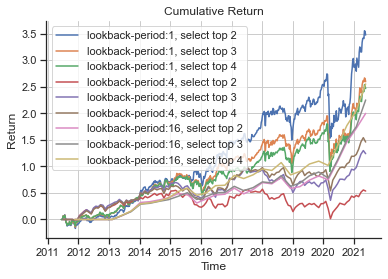

In [9]:
# Cumulative Return

fig, ax = plt.subplots()
ax.set_title('Cumulative Return')

ax.set(xlabel='Time', ylabel='Return')
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0) # the important part here

df = return_table
for t in [1,4,16]:
    for n in [2,3,4]:
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table(df, t, n).loc[portfolio_retrun_table(df, t, n).index > '2011-06-03']).cumprod()-1

        ax.plot(data, label = 'lookback-period:' + str(t) + ", select top " + str(n))
        ax.legend()



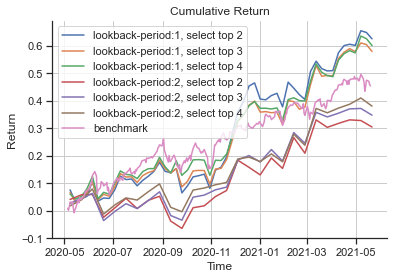

In [10]:
# Let's take a closer look

fig, ax = plt.subplots()
ax.set_title('Cumulative Return')

ax.set(xlabel='Time', ylabel='Return')
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0) # the important part here

df = return_table
for t in [1,2]:
    for n in [2,3,4]:
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table(df, t, n).loc[portfolio_retrun_table(df, t, n).index > '2020-05-04']).cumprod()-1

        ax.plot(data, label = 'lookback-period:' + str(t) + ", select top " + str(n))
        ax.legend()

# Add benchmark

df_extract = get_historical_data('SPY', start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
benchmark_return = pd.to_numeric(df_extract.changePercent)

benchmark_data = (1+benchmark_return.loc[benchmark_return.index > '2020-05-04']).cumprod()-1
ax.plot(benchmark_data, label = 'benchmark')
ax.legend()

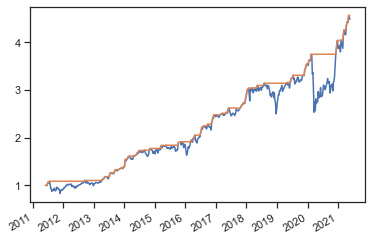

In [11]:
# plot maximum drawdown
plot_maximum_drawdown(df, 1, 2) # 1 week look-back period, with select top 2 at each rebalance